Local Moran per entity:   0%|          | 0/2 [00:00<?, ?it/s]

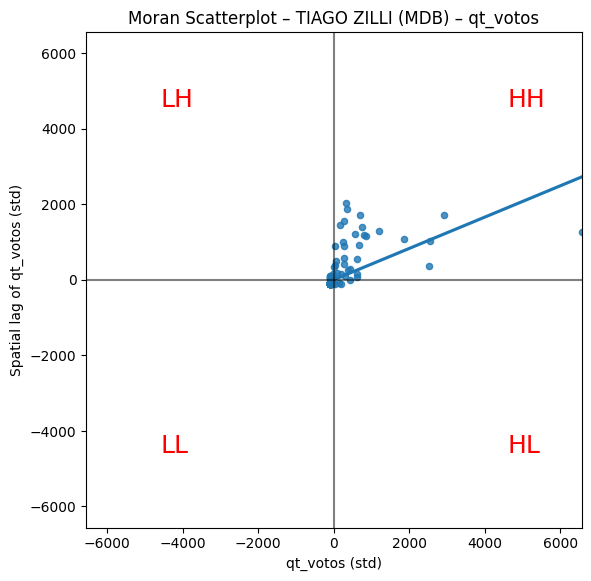

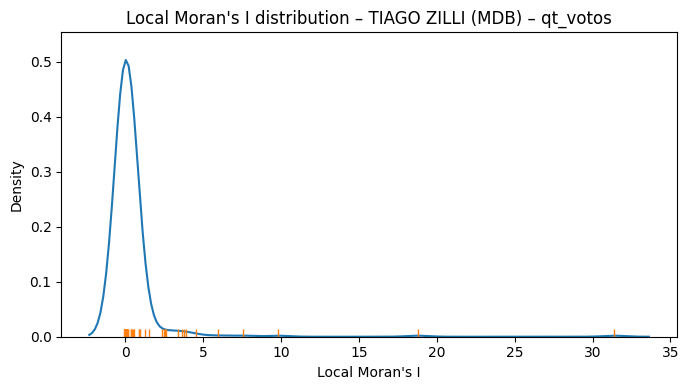

C:\Users\Diogo Neiss\AppData\Local\Temp\ipykernel_26980\1648028443.py:300: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(class_labels))


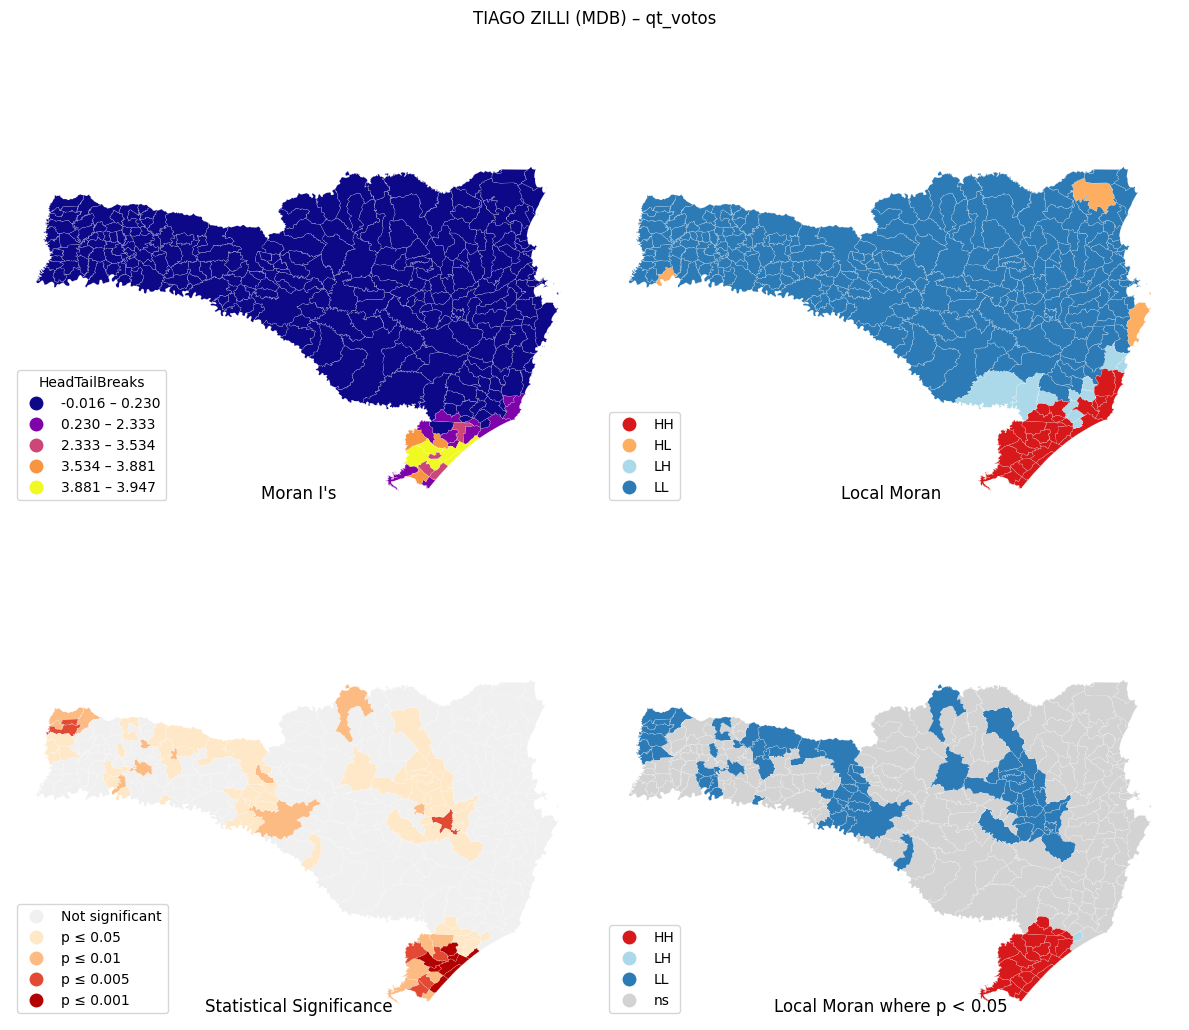

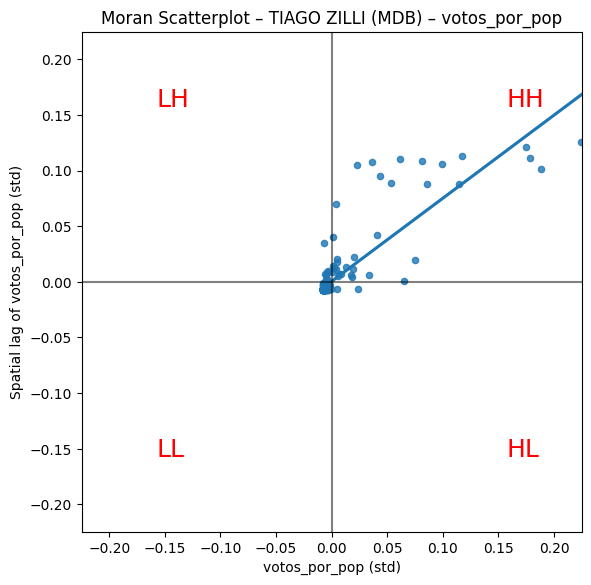

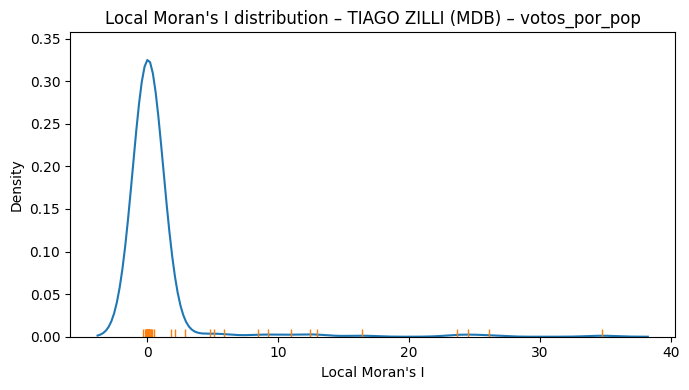

C:\Users\Diogo Neiss\AppData\Local\Temp\ipykernel_26980\1648028443.py:300: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(class_labels))


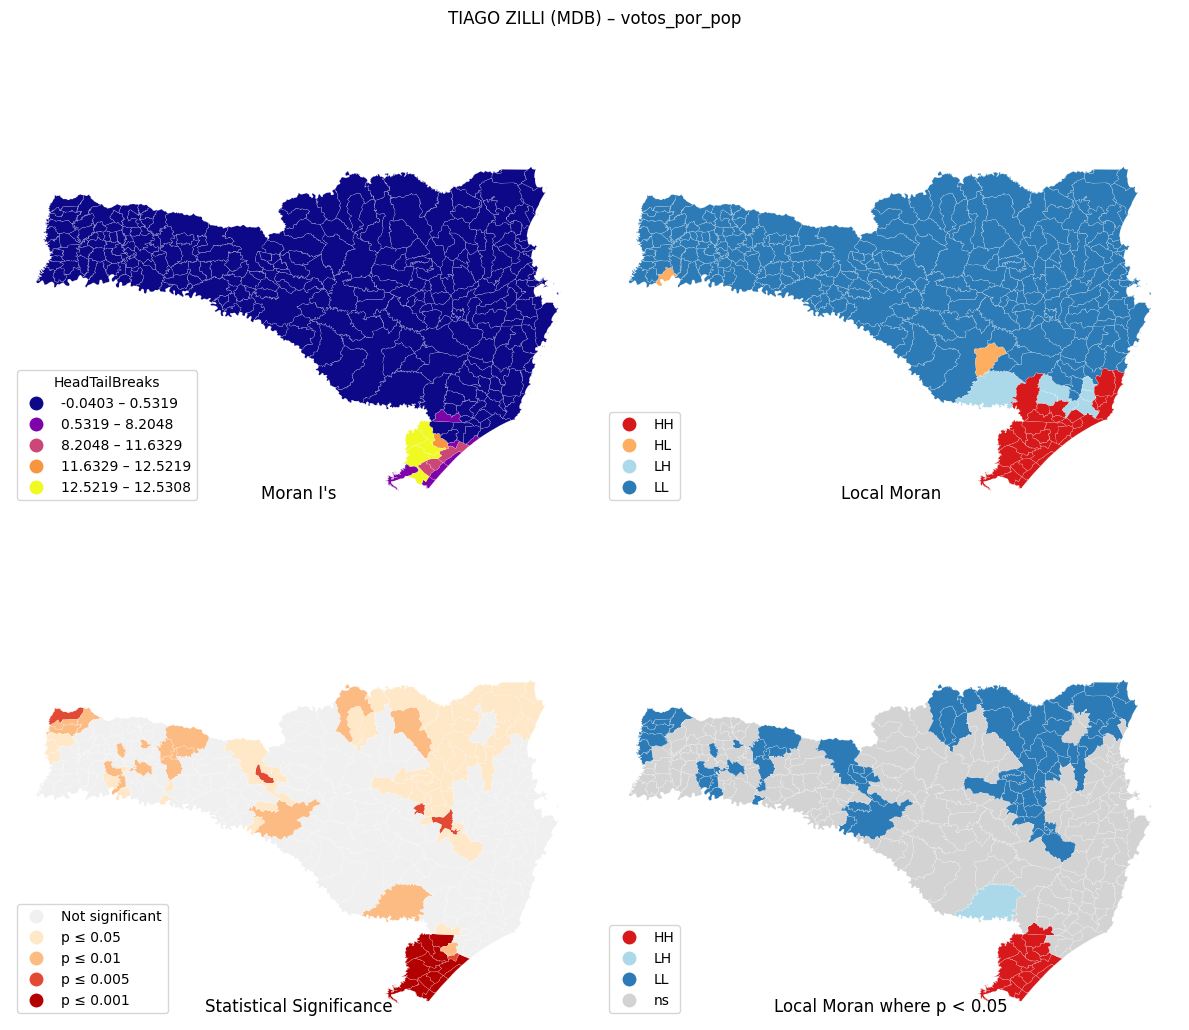

Local Moran per entity:  50%|█████     | 1/2 [00:07<00:07,  7.01s/it]

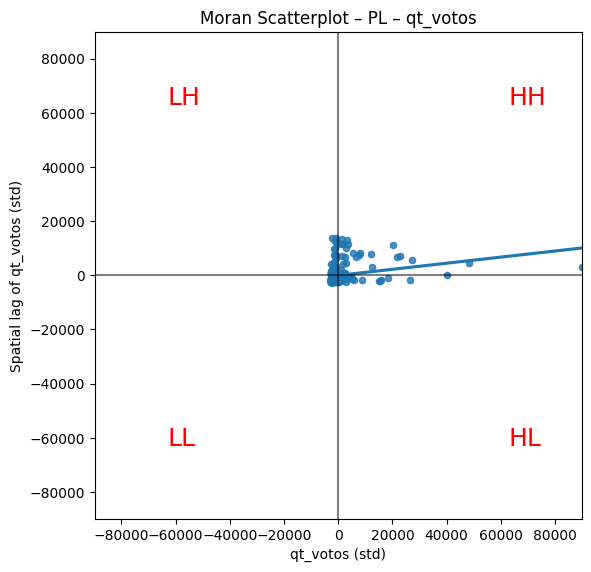

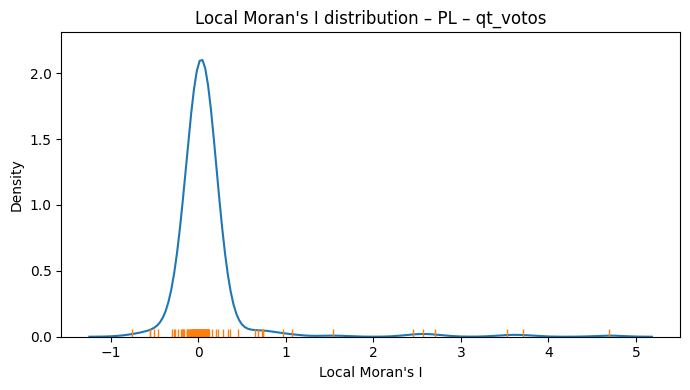

C:\Users\Diogo Neiss\AppData\Local\Temp\ipykernel_26980\1648028443.py:300: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(class_labels))


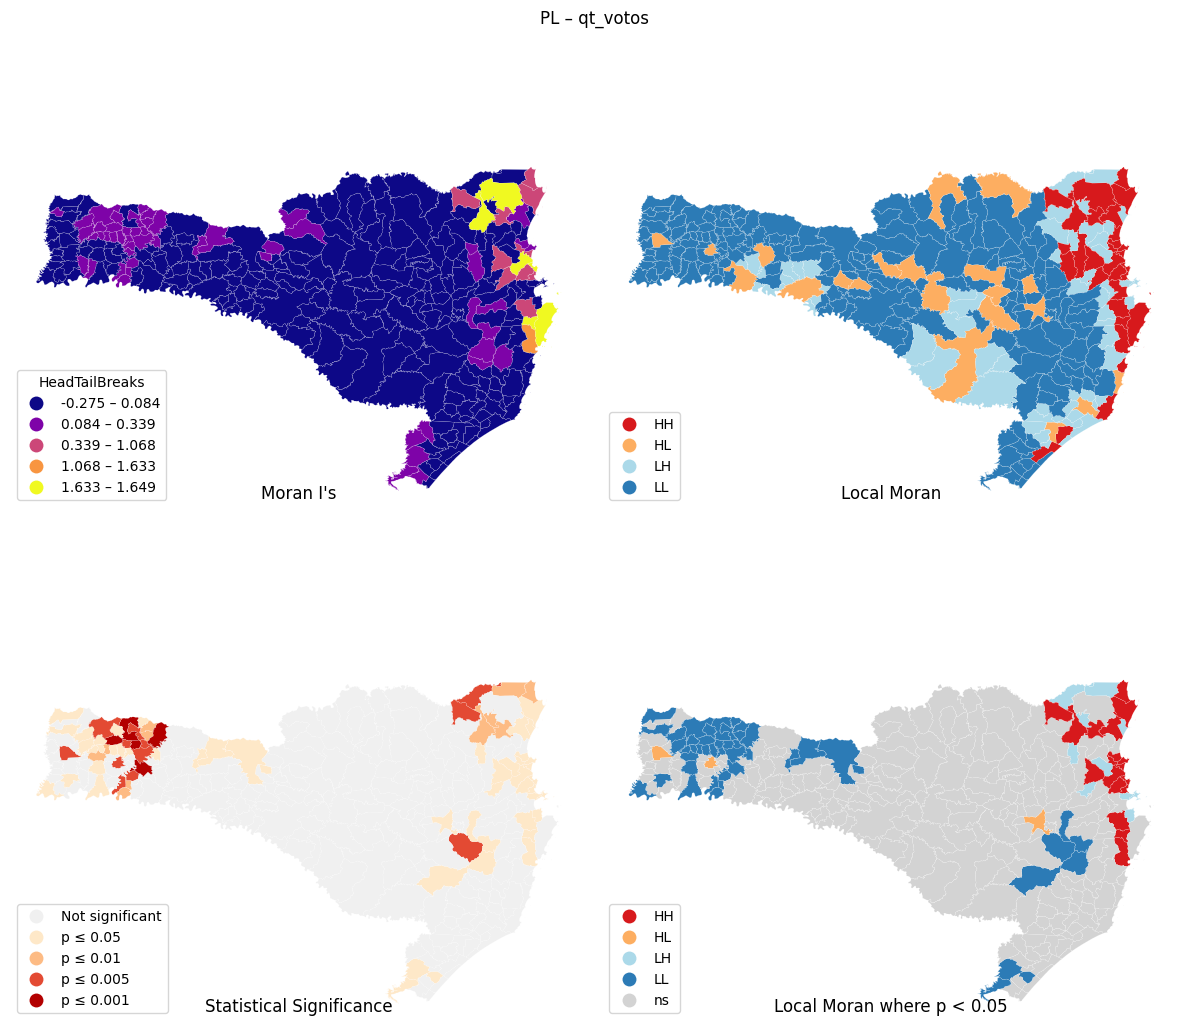

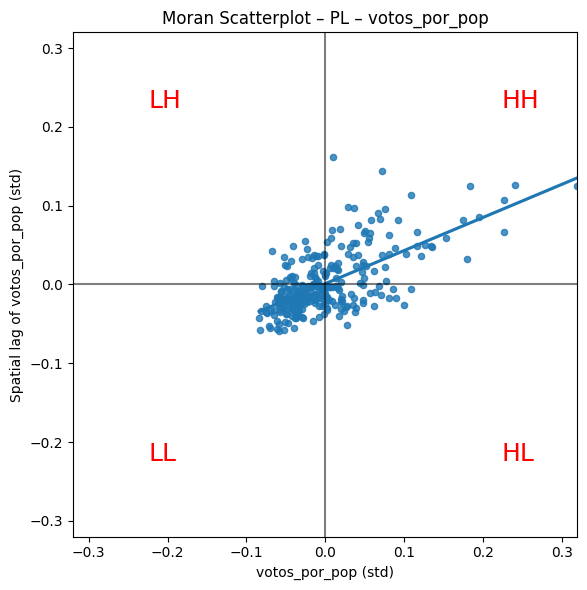

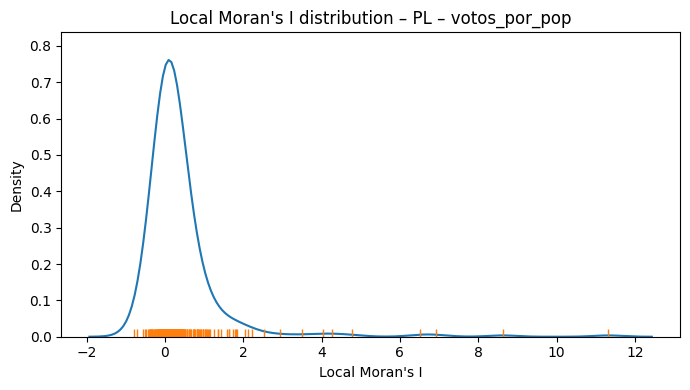

C:\Users\Diogo Neiss\AppData\Local\Temp\ipykernel_26980\1648028443.py:300: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("plasma", len(class_labels))


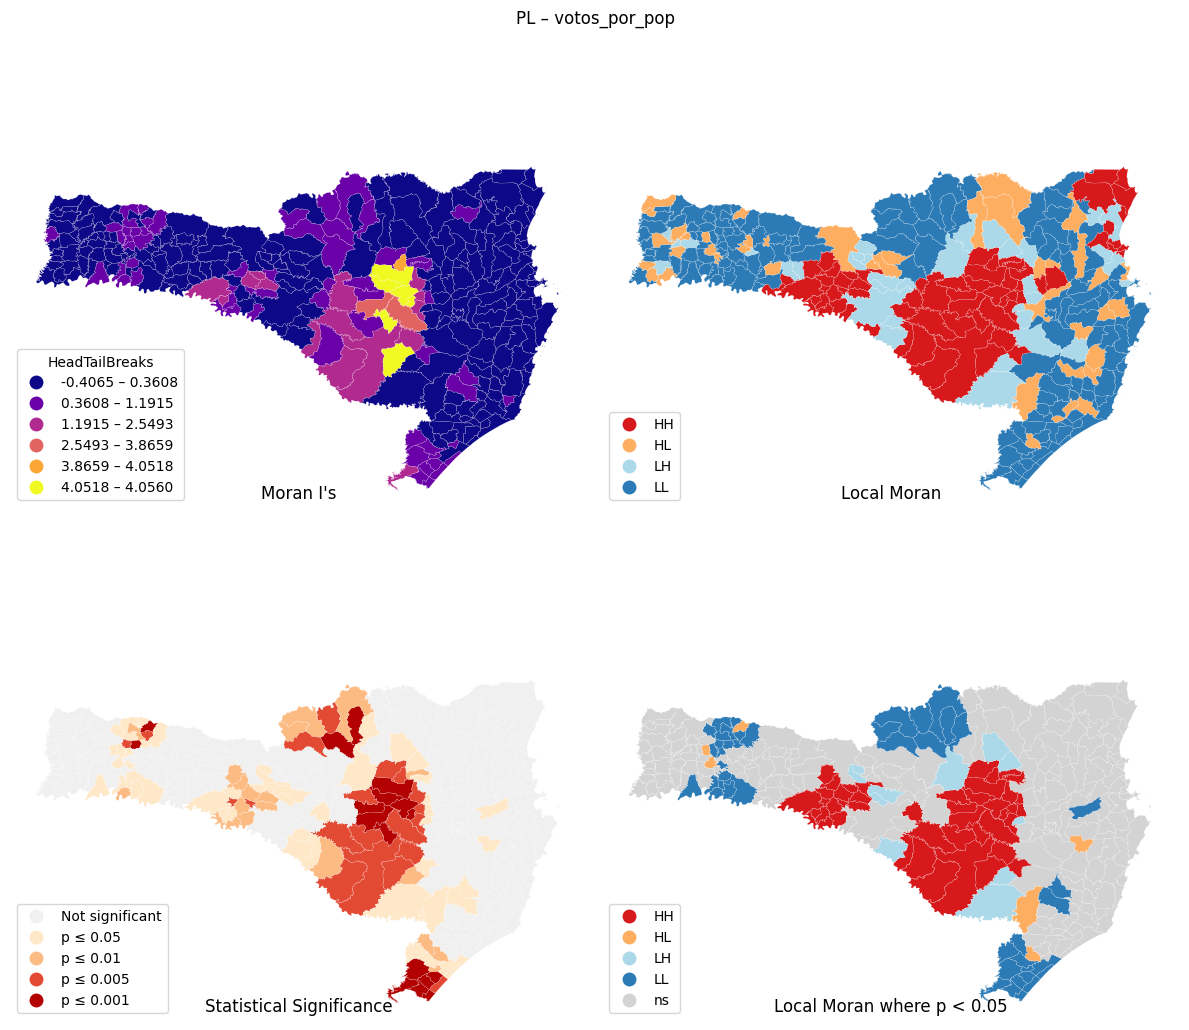

Local Moran per entity: 100%|██████████| 2/2 [00:11<00:00,  5.67s/it]


In [ ]:
# JUPYTER CELL — Local Moran (LISA) for candidates AND parties,
# for multiple target variables, saving all graphs to disk.
#
# Requirements (install if needed):
#   pip install geopandas psycopg2-binary sqlalchemy libpysal esda splot seaborn tqdm matplotlib mapclassify

import re
from pathlib import Path

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot

# Reuse your existing DB helpers
from calculate_morans import get_sqlalchemy_engine

# -------------------------------------------------------------------
# PARAMETERS
# -------------------------------------------------------------------

SHOW_PLOTS_IN_NOTEBOOK = True

# Candidates (sq_candidato) and parties (sigla_partido) to analyze
CANDIDATES = [
    "240001605911",
    # add more sq_candidato as strings here
]

PARTIES = [
    "PL",
    # add sigla_partido here
]

# Variables to analyze
TARGET_COLS = [
    "qt_votos",
    "votos_por_pop",
]

# Root folder for graphs
GRAPHS_ROOT = Path("graphs")

# SQLs
SQL_CANDIDATE = """
    SELECT
        id_municipio,
        nm_municipio,
        qt_votos,
        votos_por_pop,
        nr_votavel,
        nm_votavel,
        sq_candidato,
        sigla_partido,
        geom
    FROM eleicoes22.agg_eleicao_e_outras_bases_materialized
    WHERE sq_candidato = %(sq_candidato)s
      AND geom IS NOT NULL
"""

SQL_PARTY = """
    SELECT
        id_municipio,
        nm_municipio,
        qt_votos,
        votos_por_pop,
        sigla_partido,
        geom
    FROM eleicoes22.agg_eleicao_partidos_e_outras_bases
    WHERE sigla_partido = %(sigla_partido)s
      AND geom IS NOT NULL
"""

# -------------------------------------------------------------------
# UTILS
# -------------------------------------------------------------------

def slugify(text: str) -> str:
    text = text.strip().replace(" ", "_")
    text = re.sub(r"[^\w\-.]", "", text, flags=re.UNICODE)
    return text


# -------------------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------------------

def load_candidate_gdf(engine, sq_candidato: str) -> gpd.GeoDataFrame:
    gdf = gpd.read_postgis(
        SQL_CANDIDATE,
        engine,
        params={"sq_candidato": sq_candidato},
        geom_col="geom",
    )
    if gdf.crs is not None:
        gdf = gdf.to_crs(epsg=3857)
    return gdf


def load_party_gdf(engine, sigla_partido: str) -> gpd.GeoDataFrame:
    gdf = gpd.read_postgis(
        SQL_PARTY,
        engine,
        params={"sigla_partido": sigla_partido},
        geom_col="geom",
    )
    if gdf.crs is not None:
        gdf = gdf.to_crs(epsg=3857)
    return gdf


# -------------------------------------------------------------------
# LISA COMPUTATION (LOCAL MORAN)
# -------------------------------------------------------------------

def compute_local_moran(gdf: gpd.GeoDataFrame, col: str):
    """
    Returns (db, w, lisa)

    db: GeoDataFrame with standardized variable and spatial lag:
         - col_std
         - w_col
         - w_col_std
    w:  spatial weights object (KNN 8)
    lisa: Moran_Local object
    """
    db = gdf.dropna(subset=[col]).copy()
    if db.empty:
        return None, None, None

    y = db[col].astype(float).values

    # Standardize (centered)
    db[f"{col}_std"] = y - y.mean()

    # KNN weights
    w = weights.distance.KNN.from_dataframe(db, k=8)
    w.transform = "R"

    # Spatial lag
    db[f"w_{col}"] = weights.lag_spatial(w, db[col])
    db[f"w_{col}_std"] = weights.lag_spatial(w, db[f"{col}_std"])

    # Local Moran
    lisa = esda.moran.Moran_Local(db[col], w)

    return db, w, lisa


# -------------------------------------------------------------------
# PLOTS (MIMIC THE BOOK / GEODA-STYLE) — ALL SAVE TO DISK
# -------------------------------------------------------------------

def plot_moran_scatter(db, col, title, out_path=None, show=SHOW_PLOTS_IN_NOTEBOOK):
    """Moran scatterplot with symmetric axes around zero."""
    x = f"{col}_std"
    y = f"w_{col}_std"

    fig, ax = plt.subplots(figsize=(6, 6))

    sns.regplot(
        x=x,
        y=y,
        data=db,
        ci=None,
        ax=ax,
        scatter_kws={"s": 20}
    )

    ax.axvline(0, c="k", alpha=0.5)
    ax.axhline(0, c="k", alpha=0.5)

    max_abs_x = np.abs(db[x]).max()
    max_abs_y = np.abs(db[y]).max()
    r = max(max_abs_x, max_abs_y)

    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_aspect("equal", "box")

    ax.text(0.7 * r, 0.7 * r,   "HH", fontsize=18, c="r")
    ax.text(0.7 * r, -0.7 * r,  "HL", fontsize=18, c="r")
    ax.text(-0.7 * r, 0.7 * r,  "LH", fontsize=18, c="r")
    ax.text(-0.7 * r, -0.7 * r, "LL", fontsize=18, c="r")

    ax.set_xlabel(f"{col} (std)")
    ax.set_ylabel(f"Spatial lag of {col} (std)")
    ax.set_title(title)

    plt.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)


def plot_local_moran_distribution(lisa, title, out_path=None, show=SHOW_PLOTS_IN_NOTEBOOK):
    """KDE + rug of local Moran's I values (lisa.Is), as in the book."""
    fig, ax = plt.subplots(1, figsize=(7, 4))
    sns.kdeplot(lisa.Is, ax=ax)
    sns.rugplot(lisa.Is, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Local Moran's I")
    plt.tight_layout()
    if out_path is not None:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)


def plot_lisa_4panel(db, lisa, col, title_prefix, out_path=None, show=SHOW_PLOTS_IN_NOTEBOOK):
    """
    2x2 panel similar to the textbook (using splot.esda.lisa_cluster):

      1) Choropleth of local statistics (I_i)
      2) Scatterplot quadrant map (all obs treated as significant, p=1)
      3) Significance map with multiple p tiers
      4) Cluster map (p < 0.05)
    """
    import pandas as pd
    from matplotlib.colors import ListedColormap
    import mapclassify as mc
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    axs = axs.flatten()

    Is_raw = np.asarray(lisa.Is, dtype=float)

   # Simple heavy-tail heuristic: compare upper tail to body of distribution
    q1, q2, q3 = np.percentile(Is_raw, [25, 50, 75])
    iqr = q3 - q1
    max_val = Is_raw.max()
    min_val = Is_raw.min()

    # heavy right tail if upper tail is much longer than lower tail
    # and there is at least one positive large value
    right_tail_ratio = (max_val - q2) / (q2 - min_val + 1e-9)
    heavy_tail = (right_tail_ratio > 3) and (max_val > 0)

    # For visualization, clip extremes to avoid single huge class
    low_clip, high_clip = np.percentile(Is_raw, [2, 98])
    Is_clip = np.clip(Is_raw, low_clip, high_clip)

    # Choose classifier
    if heavy_tail:
        scheme_name = "HeadTailBreaks"
        classifier = mc.HeadTailBreaks(Is_clip)
    else:
        scheme_name = "NaturalBreaks (Jenks)"
        # choose k up to 5 but not more than unique values-1
        unique_vals = np.unique(Is_clip)
        k = min(5, max(2, len(unique_vals) - 1))
        classifier = mc.NaturalBreaks(Is_clip, k=k)

    bins = classifier.bins  # class upper bounds

    # Decide decimal places based on smallest non-zero bin width
    diffs = np.diff(np.concatenate(([Is_clip.min()], bins)))
    positive_diffs = diffs[diffs > 0]
    if len(positive_diffs) == 0:
        decimals = 3
    else:
        min_diff = positive_diffs.min()
        # more digits if classes are very tight
        decimals = int(np.ceil(-np.log10(min_diff))) + 1
        decimals = max(2, min(decimals, 6))  # clamp between 2 and 6

    fmt = f"{{:.{decimals}f}}"

    # Build labels like "[a, b]" using dynamic decimals
    lower_bounds = np.concatenate(([Is_clip.min()], bins[:-1]))
    upper_bounds = bins

    class_labels = []
    for lo, hi in zip(lower_bounds, upper_bounds):
        class_labels.append(f"{fmt.format(lo)} – {fmt.format(hi)}")

    # Assign class index and labels to GeoDataFrame
    class_idx = classifier.yb  # 0..k-1
    db_is = db.assign(
        Is_clip=Is_clip,
        Is_class_idx=class_idx,
        Is_class_label=pd.Categorical(
            [class_labels[i] for i in class_idx],
            categories=class_labels,
            ordered=True,
        ),
    )

    # Discrete colormap with same number of classes
    cmap = plt.colormaps.get_cmap("plasma").resampled(len(class_labels))
    ax = axs[0]
    db_is.plot(
        column="Is_class_label",
        categorical=True,
        legend=True,
        cmap=cmap,
        linewidth=0.1,
        edgecolor="white",
        ax=ax,
        legend_kwds={"loc": "lower left", "title":f"Clusters using {scheme_name}"},
    )

    # annotate algorithm used
    # ax.text(
    #     0.01,
    #     0.01,
    #     f"{scheme_name}\n(clipped to [{fmt.format(low_clip)}, {fmt.format(high_clip)}])",
    #     transform=ax.transAxes,
    #     fontsize=8,
    #     bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    #     va="bottom",
    #     ha="right",
    # )
    # 2) Quadrant colors (treat all as significant: p=1)
    ax = axs[1]
    esdaplot.lisa_cluster(lisa, db, p=1, ax=ax, legend_kwds={"loc": "lower left"})

    # 3) Significance map with multiple p tiers
    ax = axs[2]

    levels = [
        "Not significant",
        "p ≤ 0.05",
        "p ≤ 0.01",
        "p ≤ 0.005",
        "p ≤ 0.001",
    ]

    def p_tier(p):
        if p <= 0.001:
            return "p ≤ 0.001"
        elif p <= 0.005:
            return "p ≤ 0.005"
        elif p <= 0.01:
            return "p ≤ 0.01"
        elif p <= 0.05:
            return "p ≤ 0.05"
        return "Not significant"

    sig_labels = pd.Categorical(
        [p_tier(p) for p in lisa.p_sim],
        categories=levels,
        ordered=True,
    )

    db_sig = db.assign(sig_tier=sig_labels)

    colors = [
        "#f0f0f0",  # Not significant
        "#fee8c8",  # p ≤ 0.05
        "#fdbb84",  # p ≤ 0.01
        "#e34a33",  # p ≤ 0.005
        "#b30000",  # p ≤ 0.001
    ]
    cmap = ListedColormap(colors[:len(levels)])

    db_sig.plot(
        column="sig_tier",
        categorical=True,
        legend=True,
        legend_kwds={"loc": "lower left"},
        cmap=cmap,
        linewidth=0.1,
        edgecolor="white",
        ax=ax,
    )

    # 4) Cluster map (only significant at p<0.05)
    ax = axs[3]
    esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax, legend_kwds={"loc": "lower left"})

    titles = [
        "Moran I's",
        "Local Moran",
        "Statistical Significance",
        "Local Moran where p < 0.05",
    ]
    for i, ax in enumerate(axs):
        ax.set_axis_off()
        ax.set_title(titles[i], y=0.0)

    fig.tight_layout()
    plt.suptitle(title_prefix)

    if out_path is not None:
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close(fig)


# -------------------------------------------------------------------
# MAIN LOOP OVER ENTITIES (CANDIDATES + PARTIES) AND VARIABLES
# -------------------------------------------------------------------

engine = get_sqlalchemy_engine()
GRAPHS_ROOT.mkdir(parents=True, exist_ok=True)

# Build unified entity list: id + is_party
entities = []
for sq in CANDIDATES:
    entities.append({"id": sq, "is_party": False})
for sig in PARTIES:
    entities.append({"id": sig, "is_party": True})

for ent in tqdm(entities, desc="Local Moran per entity"):
    ent_id = ent["id"]
    is_party = ent["is_party"]

    if is_party:
        gdf = load_party_gdf(engine, ent_id)
    else:
        gdf = load_candidate_gdf(engine, ent_id)

    if gdf.empty:
        print(f"[WARN] entity={ent_id} (is_party={is_party}): no geometries found.")
        continue

    if len(gdf) < 5:
        print(f"[WARN] entity={ent_id} (is_party={is_party}): too few rows ({len(gdf)}) for meaningful LISA.")
        continue

    # Entity name for titles and folder naming
    if is_party:
        entity_name = gdf.iloc[0]["sigla_partido"]
        entity_label = entity_name  # simpler for titles
    else:
        entity_name = gdf.iloc[0]["nm_votavel"]
        sig = gdf.iloc[0]["sigla_partido"]
        entity_label = f"{entity_name} ({sig})"

    entity_folder = GRAPHS_ROOT / slugify(entity_name)
    entity_folder.mkdir(parents=True, exist_ok=True)

    for col in TARGET_COLS:
        if col not in gdf.columns:
            print(f"[WARN] entity={ent_id}: column '{col}' not found, skipping.")
            continue

        db, w, lisa = compute_local_moran(gdf, col)
        if db is None:
            print(f"[WARN] entity={ent_id}: no data for column '{col}' after dropping NA.")
            continue

        base_title = f"{entity_label} – {col}"

        # 1) Moran scatterplot
        graph_title = "moran_scatter"
        file_name = f"{slugify(graph_title)}_{slugify(entity_name)}_{slugify(col)}.png"
        out_path = entity_folder / file_name
        plot_moran_scatter(db, col, f"Moran Scatterplot – {base_title}", out_path=out_path, show=SHOW_PLOTS_IN_NOTEBOOK)

        # 2) Local Moran I distribution
        graph_title = "local_moran_distribution"
        file_name = f"{slugify(graph_title)}_{slugify(entity_name)}_{slugify(col)}.png"
        out_path = entity_folder / file_name
        plot_local_moran_distribution(lisa, f"Local Moran's I distribution – {base_title}", out_path=out_path, show=SHOW_PLOTS_IN_NOTEBOOK)

        # 3) 2x2 LISA panel
        graph_title = "lisa_4panel"
        file_name = f"{slugify(graph_title)}_{slugify(entity_name)}_{slugify(col)}.png"
        out_path = entity_folder / file_name
        plot_lisa_4panel(db, lisa, col, base_title, out_path=out_path, show=SHOW_PLOTS_IN_NOTEBOOK)
